In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
def data_gen(n_cat,n_p):
    n_tot = n_cat*n_p
    centers = np.array([[np.cos(t*2*np.pi/n_cat),np.sin(t*2*np.pi/n_cat)] for t in range(n_cat)])
    data = np.zeros((n_tot,2))
    labels = np.zeros(n_tot)
    for i in range(n_cat):
        scatter = np.random.normal(loc=centers[i],scale=.1, size=(n_p,2))
        data[i*n_p:(i+1)*n_p] = scatter
        labels[i*n_p:(i+1)*n_p] = i
    return data,labels
data,labels = data_gen(4,20)

(-1.3696462495606654,
 1.3738971260180606,
 -1.4239326663399858,
 1.3242225208537197)

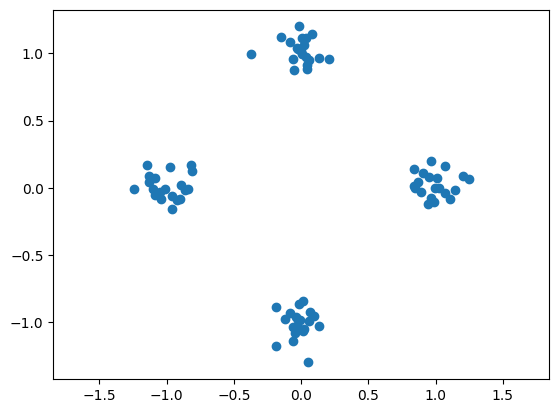

In [20]:
plt.plot(data[:,0],data[:,1],"o")
plt.axis("equal")